In [26]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from timeit import default_timer as timer
%matplotlib inline

torch.__version__

'1.13.0'

In [27]:
# Define a transform to normalize the data
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_trainsform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

# Download and load the training data
trainset = datasets.ImageFolder(root='../data/animals/train', transform=train_transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.ImageFolder(root='../data/animals/test', transform=test_trainsform)
testloader = DataLoader(testset, batch_size=64, shuffle=True)

In [28]:
# Define your network architecture here
class Network(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 16 * 16, output_shape),
        )

        
    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

# Create the network, define the criterion and optimizer
model = Network(input_shape=3, hidden_units=10, output_shape=len(trainset.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=10e-5)

model


Network(
  (conv_block1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [29]:
# Train the network here
def train_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.loss._Loss,
                optimizer: torch.optim.Optimizer,
                device: torch.device) -> float:
    """
    Train the model for one epoch.
    """
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (output.argmax(dim=1) == labels).float().mean()
    return running_loss / len(dataloader), running_acc / len(dataloader)


In [30]:
def test_step(model: torch.nn.Module,
                dataloader: torch.utils.data.DataLoader,
                criterion: torch.nn.modules.loss._Loss,
                device: torch.device) -> float:
    """
    Test the model.
    """
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.inference_mode():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            running_loss += loss.item()
            running_acc += (output.argmax(dim=1) == labels).float().mean()
    return running_loss / len(dataloader), running_acc / len(dataloader)

In [31]:
def train(model: torch.nn.Module,
            train_dataloader: torch.utils.data.DataLoader,
            test_dataloader: torch.utils.data.DataLoader,
            criterion: torch.nn.modules.loss._Loss,
            optimizer: torch.optim.Optimizer,
            device: torch.device,
            epochs: int = 10) -> None:
    train_losses, test_losses = [], []
    train_accs, test_accs = [], []
    start_time = timer()
    for e in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, trainloader, criterion, optimizer, device)
        test_loss, test_acc = test_step(model, testloader, criterion, device)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {e+1}/{epochs} | "
            f"Train loss: {train_loss:.3f} | "
            f"Train Accuracy: {train_acc*100:0.3f}% | "
            f"Test loss: {test_loss:.3f} | "
            f"Test Accuracy: {test_acc*100:0.3f}%")
    end_time = timer()
    print(f"Total time: {end_time - start_time:.2f} seconds on Device: {device}")
    return train_losses, test_losses, train_accs, test_accs

In [32]:
# print summary of model
from torchinfo import summary
summary(model, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Network                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-3                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-4                       [1, 10, 32, 32]           910
│    └─ReLU: 2-5                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-6                    [1, 10, 16, 16]           --
├─Sequential: 1-3                        [1, 3]                    --
│    └─Flatten: 2-7                      [1, 2560]                 --
│    └─Linear: 2-8                       [1, 3]                    7,683
Total params: 8,873
Trainable params: 8,873
Non-trainable params: 0
Total mult-a

In [33]:
# Train the network
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses, test_losses, train_acc, test_acc = train(model=model, train_dataloader=trainloader, test_dataloader=testloader, criterion=criterion, optimizer=optimizer, device=device, epochs=epochs)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10 | Train loss: 1.096 | Train Accuracy: 38.363% | Test loss: 1.097 | Test Accuracy: 35.104%
Epoch 2/10 | Train loss: 1.082 | Train Accuracy: 43.914% | Test loss: 1.079 | Test Accuracy: 47.188%
Epoch 3/10 | Train loss: 1.054 | Train Accuracy: 51.398% | Test loss: 1.048 | Test Accuracy: 43.906%
Epoch 4/10 | Train loss: 1.020 | Train Accuracy: 50.329% | Test loss: 1.034 | Test Accuracy: 41.458%
Epoch 5/10 | Train loss: 0.982 | Train Accuracy: 49.753% | Test loss: 1.086 | Test Accuracy: 36.979%
Epoch 6/10 | Train loss: 0.962 | Train Accuracy: 50.946% | Test loss: 1.185 | Test Accuracy: 36.198%
Epoch 7/10 | Train loss: 0.953 | Train Accuracy: 52.220% | Test loss: 1.104 | Test Accuracy: 38.229%
Epoch 8/10 | Train loss: 0.931 | Train Accuracy: 55.798% | Test loss: 1.166 | Test Accuracy: 36.979%
Epoch 9/10 | Train loss: 0.923 | Train Accuracy: 54.688% | Test loss: 1.141 | Test Accuracy: 38.542%
Epoch 10/10 | Train loss: 0.910 | Train Accuracy: 54.400% | Test loss: 1.232 | Test Accurac

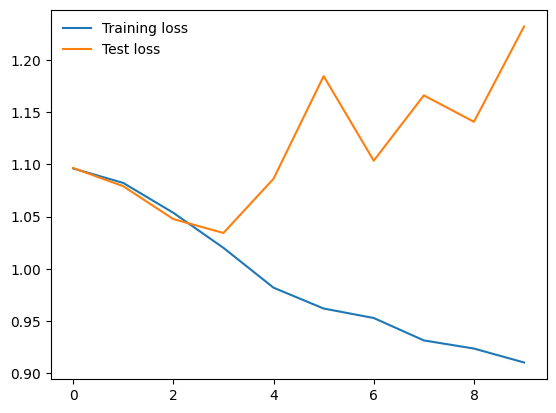

In [34]:
# Plot the training loss and test loss
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend(frameon=False)

In [35]:
from typing import Dict

def plot_predictions(model: torch.nn.Module,
                     dataloader: torch.utils.data.DataLoader,
                     classes: Dict,
                     device: torch.device) -> None:
    """
    Plot a batch of test images, their predicted labels and ground truth (correct) labels.
    """
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    with torch.inference_mode():
        output = model(images)
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        images = images.cpu().numpy()
        labels = labels.cpu().numpy()
        top_class = top_class.cpu().numpy()
        fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
        for ii in range(5):
            ax = axes[ii]
            ax.imshow(np.transpose(images[ii], (1, 2, 0)))
            ax.set_title(f"{classes[top_class[ii][0]]} == {classes[labels[ii]]}",
                        color=("green" if classes[top_class[ii][0]] == classes[labels[ii]] else "red"),
                        fontsize=9)

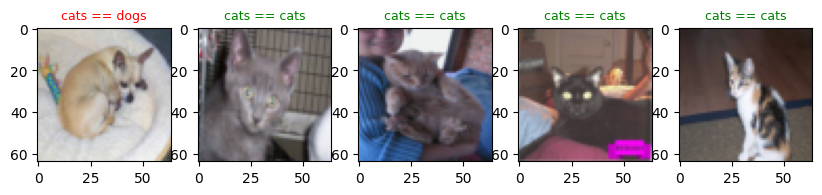

In [36]:
plot_predictions(model, testloader, trainset.classes, device)

In [37]:
from torchvision.models import resnet50

# Load the pretrained model from pytorch
model = resnet50()

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False


# Replace the last fully connected layer
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(trainset.classes))

# Move tensors to GPU if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model we just instantiated
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [39]:
epochs = 5
train_loss, test_loss, train_acc, test_acc = train(model=model, train_dataloader=trainloader, test_dataloader=testloader, criterion=criterion, optimizer=optimizer, device=device, epochs=epochs)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 | Train loss: 1.124 | Train Accuracy: 35.074% | Test loss: 1.139 | Test Accuracy: 35.677%
Epoch 2/5 | Train loss: 1.132 | Train Accuracy: 36.061% | Test loss: 1.128 | Test Accuracy: 33.854%
Epoch 3/5 | Train loss: 1.101 | Train Accuracy: 38.322% | Test loss: 1.178 | Test Accuracy: 33.750%
Epoch 4/5 | Train loss: 1.094 | Train Accuracy: 38.446% | Test loss: 1.147 | Test Accuracy: 31.719%
Epoch 5/5 | Train loss: 1.101 | Train Accuracy: 38.363% | Test loss: 1.135 | Test Accuracy: 31.823%
Total time: 535.60 seconds on Device: cpu


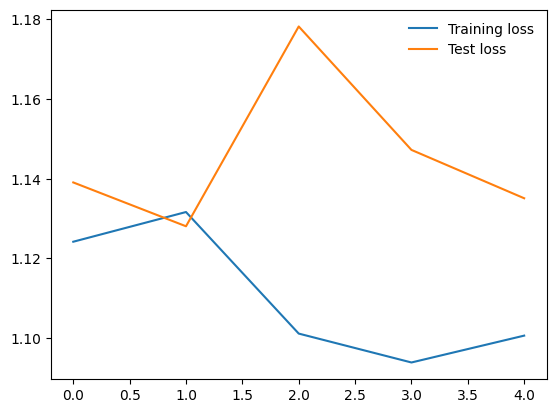

In [40]:
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Test loss')
plt.legend(frameon=False)

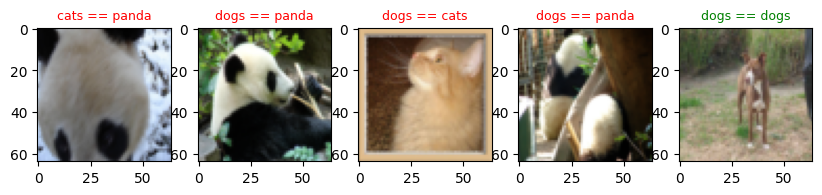

In [41]:
plot_predictions(model, testloader, trainset.classes, device)